##Задача классификации

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gkalpolukcu/knn-algorithm-dataset")

print("Path to dataset files:", path)

100%|██████████| 48.7k/48.7k [00:00<00:00, 35.6MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1


In [3]:
import pandas as pd
data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')

{'memory': None, 'steps': [('scaler', StandardScaler()), ('dtree', DecisionTreeClassifier(max_depth=4))], 'transform_input': None, 'verbose': False, 'scaler': StandardScaler(), 'dtree': DecisionTreeClassifier(max_depth=4), 'scaler__copy': True, 'scaler__with_mean': True, 'scaler__with_std': True, 'dtree__ccp_alpha': 0.0, 'dtree__class_weight': None, 'dtree__criterion': 'gini', 'dtree__max_depth': 4, 'dtree__max_features': None, 'dtree__max_leaf_nodes': None, 'dtree__min_impurity_decrease': 0.0, 'dtree__min_samples_leaf': 1, 'dtree__min_samples_split': 2, 'dtree__min_weight_fraction_leaf': 0.0, 'dtree__monotonic_cst': None, 'dtree__random_state': None, 'dtree__splitter': 'best'}


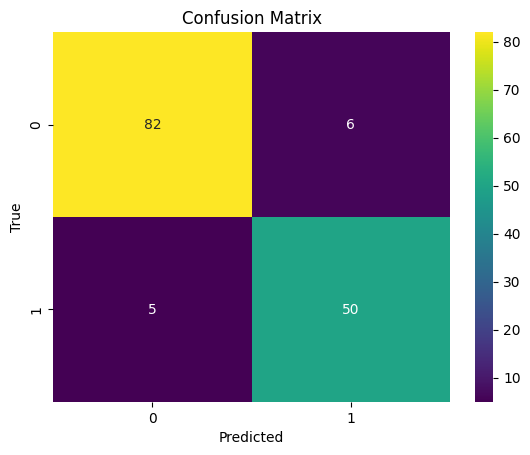

              precision    recall  f1-score   support

           B       0.94      0.93      0.94        88
           M       0.89      0.91      0.90        55

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143

ROC AUC Score: 0.9238636363636364


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline

data = data.drop(['id', 'Unnamed: 32'], axis=1)

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
dtree = DecisionTreeClassifier()
pipl = Pipeline([('scaler', scaler), ('dtree', dtree)])

param_grid = {'dtree__max_depth': np.arange(1, 21)}
final_model = GridSearchCV(estimator=pipl, param_grid=param_grid, cv=5, scoring='accuracy')

final_model.fit(X_train, y_train)

print(final_model.best_estimator_.get_params())

y_pred = final_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print(f'ROC AUC Score: {roc_auc}')

###Улучшенный бейзлайн

В качестве улучшения ограничим глубину дерева, чтобы избежать переобучения, значения для min_samples_split и min_samples_leaf увеличены, чтобы предотвратить излишнюю тонкость в разбиении данных на более мелкие группы, используется параметр class_weight='balanced' для автоматической корректировки веса классов, что поможет при сильно несбалансированных данных.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


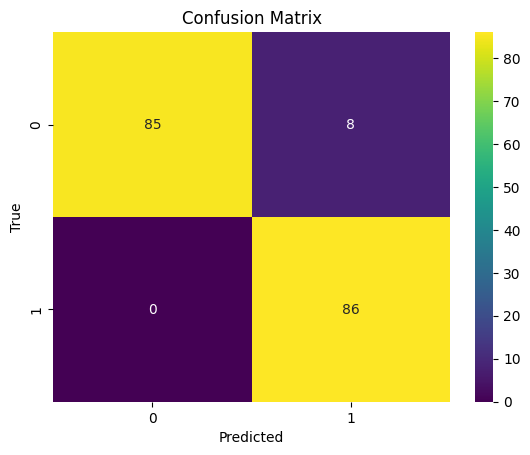

              precision    recall  f1-score   support

           B       1.00      0.91      0.96        93
           M       0.91      1.00      0.96        86

    accuracy                           0.96       179
   macro avg       0.96      0.96      0.96       179
weighted avg       0.96      0.96      0.96       179

ROC AUC Score: 0.9382345586396599


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

X = data.drop('diagnosis', axis=1)
y = data['diagnosis']

smote = SMOTE(random_state=101)
X_res, y_res = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=101)

scaler = StandardScaler()

dtree = DecisionTreeClassifier(random_state=101)

pipl = Pipeline([('scaler', scaler), ('dtree', dtree)])

param_grid = {
    'dtree__max_depth': np.arange(1, 11),
    'dtree__min_samples_split': [5, 10, 20],
    'dtree__min_samples_leaf': [2, 4, 6],
    'dtree__criterion': ['gini', 'entropy'],
    'dtree__class_weight': ['balanced', None]
}

final_model = GridSearchCV(estimator=pipl, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)

final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print(f'ROC AUC Score: {roc_auc}')


Данные изменения повысили как точность, так и ROC AUC score.

##Задача регрессии

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedevastator/netflix-imdb-scores")

print("Path to dataset files:", path)

100%|██████████| 699k/699k [00:00<00:00, 59.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes']]
y = data['imdb_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_regressor = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)

dt_regressor.fit(X_train, y_train)

y_pred = dt_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

Mean Squared Error: 1.1518103870788907
Mean Absolute Error: 0.7967894467555352
R² Score: 0.19111674504317488


###Улучшенный бейзлайн

В качестве улучшений применим нормализацию для признаков с различными шкалами (release_year, runtime, imdb_votes), настроим гиперпараметры модели с помощью GridSearchCV, добавим кросс-валидацию для оценки модели.

Best parameters from GridSearchCV: {'max_depth': 7, 'min_samples_leaf': 16, 'min_samples_split': 2}
Best cross-validation score (MSE): 1.0496268183617128
Mean Squared Error: 1.1176448086054127
Mean Absolute Error: 0.7837545426448432
R² Score: 0.21511024660656797


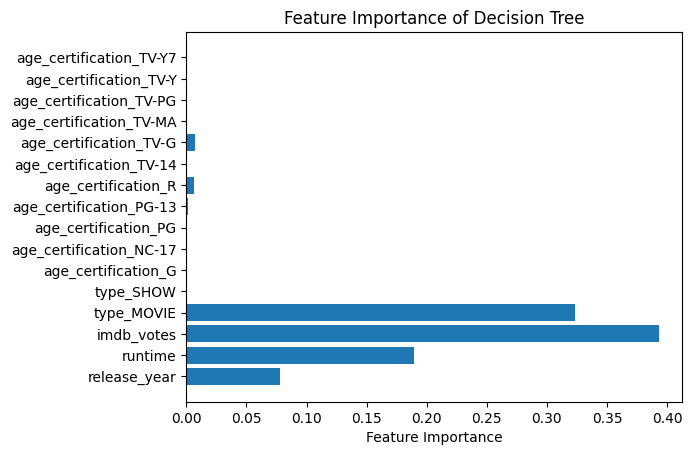

In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes', 'type', 'age_certification']]
y = data['imdb_score']

X_encoded = pd.get_dummies(X, columns=['type', 'age_certification'])

scaler = StandardScaler()
X_encoded[['release_year', 'runtime', 'imdb_votes']] = scaler.fit_transform(X_encoded[['release_year', 'runtime', 'imdb_votes']])

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

dt_regressor = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 10, 8, 9],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 5, 10, 15, 20, 16, 17, 18]
}

grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print(f'Best parameters from GridSearchCV: {grid_search.best_params_}')
print(f'Best cross-validation score (MSE): {-grid_search.best_score_}')

best_dt_regressor = grid_search.best_estimator_
best_dt_regressor.fit(X_train, y_train)

y_pred = best_dt_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

mse_scores = cross_val_score(best_dt_regressor, X_encoded, y, cv=5, scoring='neg_mean_squared_error')

feature_importances = best_dt_regressor.feature_importances_
plt.barh(X_encoded.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.title('Feature Importance of Decision Tree')
plt.show()

Результаты улучшились, но все еще не являются идеальными. Но стало понятно, что одно из главных улучшений это добавление типа шоу в признаки.

##Самостоятельная реализация

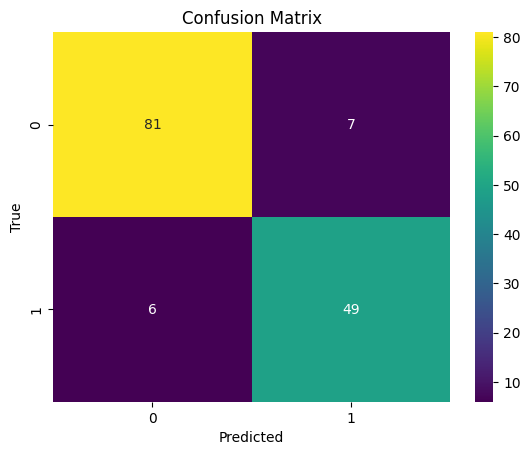

              precision    recall  f1-score   support

           0       0.93      0.92      0.93        88
           1       0.88      0.89      0.88        55

    accuracy                           0.91       143
   macro avg       0.90      0.91      0.90       143
weighted avg       0.91      0.91      0.91       143

ROC AUC Score: 0.9056818181818181


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline


class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        if len(set(y)) == 1:
            return y[0]

        if self.max_depth is not None and depth == self.max_depth:
            return self._majority_class(y)

        best_split = self._best_split(X, y)
        if best_split is None:
            return self._majority_class(y)

        left_X, left_y, right_X, right_y = self._split(X, y, best_split)
        left_branch = self._build_tree(left_X, left_y, depth + 1)
        right_branch = self._build_tree(right_X, right_y, depth + 1)

        return {
            'split': best_split,
            'left': left_branch,
            'right': right_branch
        }

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_split = None
        n_features = X.shape[1]

        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold

                left_y = y[left_indices]
                right_y = y[right_indices]

                gini = self._gini_index(left_y, right_y)
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_index, threshold)

        return best_split

    def _gini_index(self, left_y, right_y):
        left_size = len(left_y)
        right_size = len(right_y)
        total_size = left_size + right_size

        left_gini = 1 - sum([(np.sum(left_y == c) / left_size) ** 2 for c in np.unique(left_y)])
        right_gini = 1 - sum([(np.sum(right_y == c) / right_size) ** 2 for c in np.unique(right_y)])

        return (left_size / total_size) * left_gini + (right_size / total_size) * right_gini

    def _split(self, X, y, split):
        feature_index, threshold = split
        feature_values = X[:, feature_index]

        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold

        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        return left_X, left_y, right_X, right_y

    def _majority_class(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._predict_row(x, self.tree) for x in X])

    def _predict_row(self, x, tree):
        if isinstance(tree, dict):
            feature_index, threshold = tree['split']
            if x[feature_index] <= threshold:
                return self._predict_row(x, tree['left'])
            else:
                return self._predict_row(x, tree['right'])
        else:
            return tree


data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

X = data.drop('diagnosis', axis=1).values
y = np.where(data['diagnosis'] == 'M', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tree = DecisionTree(max_depth=5)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_auc}')


###Улучшенный бейзлайн

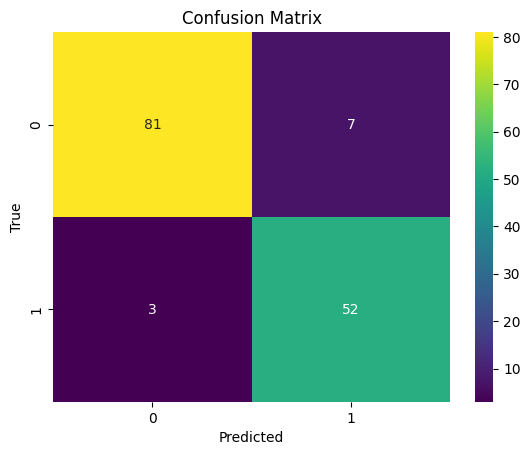

              precision    recall  f1-score   support

           0       0.96      0.92      0.94        88
           1       0.88      0.95      0.91        55

    accuracy                           0.93       143
   macro avg       0.92      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143

ROC AUC Score: 0.9329545454545454


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.tree = None
        self.class_weights = None

    def fit(self, X, y):
        if self.class_weight == 'balanced':
            self.class_weights = self._compute_class_weights(y)
        self.tree = self._build_tree(X, y)

    def _compute_class_weights(self, y):
        class_counts = np.bincount(y)
        total_samples = len(y)
        class_weights = total_samples / (len(np.unique(y)) * class_counts)
        return dict(zip(np.unique(y), class_weights))

    def _build_tree(self, X, y, depth=0):
        if len(set(y)) == 1:
            return y[0]

        if self.max_depth is not None and depth == self.max_depth:
            return self._majority_class(y)

        if len(y) < self.min_samples_split:
            return self._majority_class(y)

        best_split = self._best_split(X, y)
        if best_split is None:
            return self._majority_class(y)

        left_X, left_y, right_X, right_y = self._split(X, y, best_split)
        left_branch = self._build_tree(left_X, left_y, depth + 1)
        right_branch = self._build_tree(right_X, right_y, depth + 1)

        return {
            'split': best_split,
            'left': left_branch,
            'right': right_branch
        }

    def _best_split(self, X, y):
        best_gini = float('inf')
        best_split = None
        n_features = X.shape[1]

        for feature_index in range(n_features):
            feature_values = X[:, feature_index]
            thresholds = np.unique(feature_values)

            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold

                left_y = y[left_indices]
                right_y = y[right_indices]

                if len(left_y) < self.min_samples_leaf or len(right_y) < self.min_samples_leaf:
                    continue

                gini = self._gini_index(left_y, right_y)
                if gini < best_gini:
                    best_gini = gini
                    best_split = (feature_index, threshold)

        return best_split

    def _gini_index(self, left_y, right_y):
        left_size = len(left_y)
        right_size = len(right_y)
        total_size = left_size + right_size

        left_gini = 1 - sum([(np.sum(left_y == c) / left_size) ** 2 for c in np.unique(left_y)])
        right_gini = 1 - sum([(np.sum(right_y == c) / right_size) ** 2 for c in np.unique(right_y)])

        return (left_size / total_size) * left_gini + (right_size / total_size) * right_gini

    def _split(self, X, y, split):
        feature_index, threshold = split
        feature_values = X[:, feature_index]

        left_indices = feature_values <= threshold
        right_indices = feature_values > threshold

        left_X, left_y = X[left_indices], y[left_indices]
        right_X, right_y = X[right_indices], y[right_indices]

        return left_X, left_y, right_X, right_y

    def _majority_class(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._predict_row(x, self.tree) for x in X])

    def _predict_row(self, x, tree):
        if isinstance(tree, dict):
            feature_index, threshold = tree['split']
            if x[feature_index] <= threshold:
                return self._predict_row(x, tree['left'])
            else:
                return self._predict_row(x, tree['right'])
        else:
            return tree


data = pd.read_csv('/root/.cache/kagglehub/datasets/gkalpolukcu/knn-algorithm-dataset/versions/1/KNNAlgorithmDataset.csv')
data = data.drop(['id', 'Unnamed: 32'], axis=1)

X = data.drop('diagnosis', axis=1).values
y = np.where(data['diagnosis'] == 'M', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

tree = DecisionTree(
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced'
)

tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC Score: {roc_auc}')


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class DecisionTreeRegressorCustom:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.tree = None

    def fit(self, X, y):
        self.tree = self._build_tree(X, y)

    def predict(self, X):
        return [self._predict_node(x, self.tree) for x in X]

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        if n_samples >= self.min_samples_split and depth < self.max_depth:
            best_split = self._best_split(X, y, n_features)
            if best_split is not None:
                left_tree = self._build_tree(*best_split['left'], depth + 1)
                right_tree = self._build_tree(*best_split['right'], depth + 1)
                return {'feature': best_split['feature'],
                        'threshold': best_split['threshold'],
                        'left': left_tree,
                        'right': right_tree}
        return np.mean(y)

    def _best_split(self, X, y, n_features):
        best_split = None
        min_mse = float('inf')

        for feature in range(n_features):
            possible_thresholds = np.unique(X[:, feature])
            for threshold in possible_thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                left_y, right_y = y[left_mask], y[right_mask]

                if len(left_y) >= self.min_samples_leaf and len(right_y) >= self.min_samples_leaf:
                    mse = self._calculate_mse(left_y, right_y)
                    if mse < min_mse:
                        min_mse = mse
                        best_split = {
                            'feature': feature,
                            'threshold': threshold,
                            'left': (X[left_mask], left_y),
                            'right': (X[right_mask], right_y)
                        }
        return best_split

    def _calculate_mse(self, left_y, right_y):
        left_mean = np.mean(left_y)
        right_mean = np.mean(right_y)
        left_mse = np.mean((left_y - left_mean) ** 2)
        right_mse = np.mean((right_y - right_mean) ** 2)
        return (len(left_y) * left_mse + len(right_y) * right_mse) / (len(left_y) + len(right_y))

    def _predict_node(self, x, node):
        if isinstance(node, dict):
            if x[node['feature']] <= node['threshold']:
                return self._predict_node(x, node['left'])
            else:
                return self._predict_node(x, node['right'])
        return node


data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes']].values
y = data['imdb_score'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_regressor = DecisionTreeRegressorCustom(max_depth=5, min_samples_split=10, min_samples_leaf=5)
dt_regressor.fit(X_train, y_train)

y_pred = dt_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')


Mean Squared Error: 1.1527020345475867
Mean Absolute Error: 0.7975390594175519
R² Score: 0.190490566711356


###Улучшенный бейзлайн

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

data = pd.read_csv('/root/.cache/kagglehub/datasets/thedevastator/netflix-imdb-scores/versions/2/Netflix TV Shows and Movies.csv')

data['imdb_votes'] = data['imdb_votes'].fillna(data['imdb_votes'].mean())
data['age_certification'] = data['age_certification'].fillna(data['age_certification'].mode()[0])

X = data[['release_year', 'runtime', 'imdb_votes', 'type', 'age_certification']]
y = data['imdb_score']

X_encoded = pd.get_dummies(X, columns=['type', 'age_certification'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

dt_regressor = DecisionTreeRegressor(random_state=42)

param_grid = {
    'max_depth': [7],
    'min_samples_leaf': [16],
    'min_samples_split': [2]
}

grid_search = GridSearchCV(estimator=dt_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

grid_search.fit(X_train, y_train)

best_dt_regressor = grid_search.best_estimator_

y_pred = best_dt_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R² Score: {r2}')

cv_scores = cross_val_score(best_dt_regressor, X_scaled, y, cv=5, scoring='neg_mean_squared_error')
print(f'Cross-validated MSE: {-cv_scores.mean()}')


Mean Squared Error: 1.1176448086054127
Mean Absolute Error: 0.7837545426448432
R² Score: 0.21511024660656797
Cross-validated MSE: 1.1262753622837383


В целом, улучшения актуальные для встроенных моделей актуальны и для собственной реализации, но в целом точность встроенных выше.